# SBD on nuclear shell model

In [4]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.utils_quasiparticle_approximation import HardcoreBosonsBasis
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.fermi_hubbard_library import FemionicBasis
import numpy as np
from typing import List, Dict
from scipy.linalg import expm
import scipy
from scipy.sparse.linalg import expm_multiply
from scipy.optimize import minimize
from scipy.sparse import coo_matrix
from scipy.sparse import lil_matrix
from scipy.optimize import minimize
from scipy import sparse
from src.hartree_fock_library import HFEnergyFunctional,HFEnergyFunctionalNuclear
import torch
import torch.nn as nn
import torch.optim as optim


file_name='data/cki'

SPS=SingleParticleState(file_name=file_name)

In [5]:
nparticles_a=4
nparticles_b=2 # Berillium

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$O'

Exact solution:

In [6]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

####
H = NSMHamiltonian.hamiltonian # hamiltonian as sparse matrix
basis = NSMHamiltonian.basis # basis
###

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1) # exact solution, later to confront
psi0 = psi0.reshape(-1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 12 6
Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  8.55it/s]
1424it [00:01, 737.50it/s]


[-39.4534158]
total_m= 5.4969050145015075e-17
dimension= 51


Hartree-Fock

Load the two-body matrix

In [4]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  6.80it/s]


In [7]:

#model=HFEnergyFunctional(h_vec=torch.tensor(SPS.energies),V_dict=twobody_matrix,num_particles=nparticles_a+nparticles_b)
model=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=nparticles_a,num_protons=nparticles_b,neutron_indices=0,proton_indices=size_a)

optimizer = optim.Adam(model.parameters(), lr=0.01)

num_steps = 600
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

Step    0 | Energy = -18.654127
Step   20 | Energy = -23.157318
Step   40 | Energy = -27.103947
Step   60 | Energy = -31.144436
Step   80 | Energy = -32.195399
Step  100 | Energy = -32.675352
Step  120 | Energy = -33.068493
Step  140 | Energy = -33.466555
Step  160 | Energy = -33.827171
Step  180 | Energy = -34.051166
Step  200 | Energy = -34.136633
Step  220 | Energy = -34.158373
Step  240 | Energy = -34.162731
Step  260 | Energy = -34.163475
Step  280 | Energy = -34.163579
Step  300 | Energy = -34.163589
Step  320 | Energy = -34.163590
Step  340 | Energy = -34.163590
Step  360 | Energy = -34.163590
Step  380 | Energy = -34.163590
Step  400 | Energy = -34.163590
Step  420 | Energy = -34.163590
Step  440 | Energy = -34.163590
Step  460 | Energy = -34.163590
Step  480 | Energy = -34.163590
Step  500 | Energy = -34.163590
Step  520 | Energy = -34.163590
Step  540 | Energy = -34.163590
Step  560 | Energy = -34.163590
Step  580 | Energy = -34.163590
Step  599 | Energy = -34.163590


In [8]:
def slater_determinants_combined(C_n, C_p, fock_basis):
    """
    C_n: [M_half, N_n]  -- neutron orbitals
    C_p: [M_half, N_p]  -- proton orbitals
    fock_basis: [F, M]  -- full occupation basis (neutrons + protons)

    Returns:
        psi: [F]  -- Slater determinant amplitudes
    """
    F, M = fock_basis.shape
    M_half = M // 2
    N_n = C_n.shape[1]
    N_p = C_p.shape[1]

    psi = torch.zeros(F, dtype=C_n.dtype)

    for i in range(F):
        occ = fock_basis[i]  # [M]

        occ_n = torch.nonzero(occ[:M_half]).squeeze()
        occ_p = torch.nonzero(occ[M_half:]).squeeze()+M_half

        Cn_sub = C_n[occ_n, :]  # shape [N_n, N_n]
        Cp_sub = C_p[occ_p, :]  # shape [N_p, N_p]

        if Cn_sub.shape[0] != N_n or Cp_sub.shape[0] != N_p:
            # Skip invalid configurations (e.g., wrong number of particles)
            continue

        det_n = torch.det(Cn_sub)
        det_p = torch.det(Cp_sub)
        psi[i] = det_n * det_p


    return psi  # [F]

def slater_determinants_only_neutrons(C_n, fock_basis):
    """
    C_n: [M_half, N_n]  -- neutron orbitals
    C_p: [M_half, N_p]  -- proton orbitals
    fock_basis: [F, M]  -- full occupation basis (neutrons + protons)

    Returns:
        psi: [F]  -- Slater determinant amplitudes
    """
    F, M = fock_basis.shape
    M_half = M // 2
    N_n = C_n.shape[1]


    psi = torch.zeros(F, dtype=C_n.dtype)

    for i in range(F):
        occ = fock_basis[i]  # [M]

        occ_n = torch.nonzero(occ[:M_half]).squeeze()


        Cn_sub = C_n[occ_n, :]  # shape [N_n, N_n]




        det_n = torch.det(Cn_sub)

        psi[i] = det_n 

    return psi  # [F]


In [9]:

#psi_hf=slater_determinants_only_neutrons(model.C_n, torch.tensor(NSMHamiltonian.basis))
psi_hf=slater_determinants_combined(model.C_n, model.C_p, torch.tensor(NSMHamiltonian.basis))

psi_hf=psi_hf.detach().numpy()

psi_hf=psi_hf/np.linalg.norm(psi_hf)

In [10]:


print(psi_hf.conjugate() @ NSMHamiltonian.hamiltonian @ psi_hf)
print(psi_hf.shape)
print('fidelity=',psi0[:].conjugate().dot(psi_hf)*np.conjugate(psi0[:].conjugate().dot(psi_hf)))

-35.68670852050728
(51,)
fidelity= 0.6207778366019057


Voglio una classe Nuclear shell model sqd ansatz (trova un nome migliore hahah), i suoi parametri sono H e la base oppure numero particelle e per il resto fa automatico. Voglio i seguenti metodi:
- Inizializzazione stato con lo stato della base con minore energia
- Creazione operator pool
- compute state con produttoria delle unitarie ottenute esponenziando la somma degli operatori nell'operator pool sommati con il loro complesso coniugato fatta con scipy exp multiply applicato a stato precedente (se prima iter a quello dell'inizializzazione)
- fare SQD con quello stato e stimare energia con SQD

In secondo momento sarà da aggiungere anche minimizzazione energia!!!


In [35]:
import itertools
from scipy.optimize import dual_annealing
from typing import Optional
from cma import CMAEvolutionStrategy



class NSM_SQD_circuit_ansatz:

    def __init__(self,twobody_matrix:Dict, NSMHamiltonian, samples = 20, batches =100, train_steps = 10,num_parameters=30):



        self.NSMHamiltonian=NSMHamiltonian
        self.twobody_matrix=twobody_matrix
        ####
        self.H = NSMHamiltonian.hamiltonian # hamiltonian as sparse matrix
        self.basis = NSMHamiltonian.basis # basis
        ###

        self.l = len(self.basis[0]) # lunghezza un elemento base
        self.psi = np.zeros(len(self.basis))
        self.E = 0.

        self.seed = 1024

        self.samples = samples # number of samples for sqd energy estimation
        self.batches = batches # different batches for sqd to make an average of the energy
        self.train_steps = train_steps # steps in optimization
        self.num_parameters = num_parameters # number of parameters in the ansatz

    def initialize_state_minslater(self): # ref state is the element of the basis with the minimum energy
        self.psi = np.zeros(len(self.basis))  
        diag = self.H.diagonal()
        min_state_idx = diag.argmin()
        self.psi[min_state_idx] = 1. 
        self.psi /= np.linalg.norm(self.psi)
        self.E = diag.min()
        return None

    def initialize_state_random(self,ns): # ref state is the element of the basis with the minimum energy
        self.psi = np.zeros(len(self.basis)) 
        diag = self.H.diagonal()
        min_indices = np.argsort(diag)[:ns]
        self.psi[min_indices] = 1. / np.sqrt(ns)
        self.psi /= np.linalg.norm(self.psi)
        self.E = diag[min_indices].mean()
        return None

    def initialize_state_hartreefock(self,psi_hf): # ref state is the element of the basis with the minimum energy
        self.psi = psi_hf
        self.E = self.psi.transpose().conj() @ self.H @ self.psi
        return None


    def create_operator_pool_twobody_symmetry(self,original_operator_pool): # nella pool two body op che rispettano i miquel constraints
        
        self.operator_pool=original_operator_pool
        vs, ops, keys = [], [], []
        for key, op in self.operator_pool.items():
            if key in self.twobody_matrix:
                vs.append(self.twobody_matrix[key])
                ops.append(op)
                keys.append(key)

        vs = np.abs(np.array(vs))
        selection = np.argsort(vs)[-self.num_parameters:][::-1]
        selected_vs = vs[selection]


        new_operator_pool = {keys[idx]: ops[idx] for idx in selection}
        self.operator_pool = new_operator_pool
        self.operator_pool_list = list(self.operator_pool.values())
        np.random.seed(self.seed) 
        self.weights = np.zeros(len(self.operator_pool))#np.random.uniform(-1.3, 1.3, size=len(self.operator_pool))
        return None

    def forward(self, weights): # compute psi
        psi = self.psi.copy()
        if self.weights is not(None):
            
            for i, w in enumerate(weights):
                # print(np.conj(expm(self.weights[i] * op).T) @ expm(self.weights[i] * op))
                psi = scipy.sparse.linalg.expm_multiply( (0. + 1j) * w * self.operator_pool_list[i],psi) 
                psi = psi / np.linalg.norm(psi)

        return psi

    def SQD(self, weights): #output è energia stimata con SQD (compute energy functional)
        psi = self.forward(weights)
        prob = (np.conjugate(psi) * psi).real # .real needed to change data type from complex to float
        self.prob=prob.copy()
        Ham = self.H.copy()
        np.random.seed(self.seed) # seed con cui calcolo il vettore random i cui elementi sono i seed dei diversi batch
        seeds = np.random.randint(1, 30002, size=self.batches)
        e = np.zeros(self.batches)
        self.psi_batches=np.zeros((self.batches,self.psi.shape[0]))
        for k,s in enumerate(seeds):
            np.random.seed(s)
            #print('non zero prob=',np.nonzero(prob)[0].shape[0])

            
            if np.nonzero(prob)[0].shape[0]<self.samples:
                raw_selection = np.random.choice(len(self.basis), size=self.samples * 5, replace=True, p=prob)
                # oversample to increase chance of enough unique values
                selection = []
                seen = set()
                for idx in raw_selection:
                    if idx not in seen:
                        seen.add(idx)
                        selection.append(idx)
                    if len(selection) == self.samples:
                        break

                # In case not enough unique indices are collected, pad with random ones
                if len(selection) < self.samples:
                    remaining = list(set(range(len(self.basis))) - seen)
                    np.random.shuffle(remaining)
                    selection.extend(remaining[: self.samples - len(selection)])

                selection = np.array(selection)

            else:
                
                raw_selection = np.random.choice(len(self.basis), size=self.samples * 5, replace=True, p=prob)
                # oversample to increase chance of enough unique values
                selection = []
                seen = set()
                for idx in raw_selection:
                    if idx not in seen:
                        seen.add(idx)
                        selection.append(idx)
                    if len(selection) == self.samples:
                        break

                # In case not enough unique indices are collected, pad with random ones
                if len(selection) < self.samples:
                    remaining = list(set(range(len(self.basis))) - seen)
                    np.random.shuffle(remaining)
                    selection.extend(remaining[: self.samples - len(selection)])

                selection = np.array(selection)

            if len(selection)!=1:    
                effective_hamiltonian=  Ham.tocsr()[selection,:][:,selection]

                value,eighvec = eigsh(effective_hamiltonian, k=1, which="SA", maxiter=int(1E6), ) # Diagonalization of reduced H
                e[k]=value[0]
                self.psi_batches[k,selection]=eighvec[:,0]
            
            else:
                e[k]=Ham[selection[0],selection[0]]
            
        self.variance=np.std(e)
        return np.average(e)
    
    def cobyla_callback(self, x):
        # Callback function for COBYLA (optional, for printing intermediate results)
        print(f"Current COBYLA weights: {np.linalg.norm(x)}, SQD: {self.SQD(x)} Variance energy {self.variance}")
        self.weights = x
    def optimization(self):

                    
        for i in range(self.train_steps):
            # COBYLA optimization
            res2 = minimize(self.SQD,
                            x0=self.weights,
                            method='L-BFGS-B', #'COBYLA', #'Nelder-Mead', #'L-BFGS-B', #'Powell', # method for optimization
                            options={'disp':True,"iprint": 2},
                            callback=self.cobyla_callback,
                            #maxiter=200,       # number of iterations
                            #maxfun=1000,       # max evaluations
                            )

            self.weights = res2.x  # update weights
            self.E = self.SQD(self.weights)
            self.psi = self.forward(self.weights)

            print(f'\n--- Training Step {i+1} ---')
            print('Optimization Success =', res2.success)
            print('Energy (SQD) =', self.E)
            print('Message =', res2.message)
            print('Current weights =', self.weights)
            print('Number of function evaluations =', res2.nfev)


    def optimization_annealing(self):
        """
        Optimization routine using dual annealing (simulated annealing variant).
        """

        # Define bounds for parameters
        # (scale according to expected operator weight range, e.g. [-2, 2])
        bounds = [(-2.0, 2.0)] * len(self.weights)

        for i in range(self.train_steps):
            print(f"\n--- Simulated Annealing Step {i+1} ---")

            res = dual_annealing(
                self.SQD,
                bounds=bounds,
                #maxiter=200,       # number of annealing iterations
                #maxfun=5000,       # max evaluations
                seed=self.seed+i,  # different seed per step for exploration
                callback=self.annealing_callback,
            )

            # Update weights and state
            self.weights = res.x
            self.E = self.SQD(self.weights)
            self.psi = self.forward(self.weights)

            print("Optimization Success =", res.success)
            print("Energy (SQD) =", self.E)
            print("Message =", res.message)
            print("Current weights =", self.weights)
            print("Number of function evaluations =", res.nfev)

    def optimization_new(self,):
        
        es = CMAEvolutionStrategy(self.weights, 1, {
        'maxiter': 2000,       # maximum number of iterations
        'verb_disp': 1,     # display every iteration (set 10 for every 10 iterations)
        'verb_log': 1,      # write log files every iteration
        'verb_time': 1,     # print timing info
        'verb_append': 0,   # overwrite logs instead of appending
        'popsize': 50,         # number of samples per iteration
        'tolx': 1e-8,          # stop if change in x is small
        })

        res = es.optimize(self.SQD)

        print("Best solution:", res.result.xbest)
        print("Best function value:", res.result.fbest)
                
    def annealing_callback(self,x, f, context,*args):
        print(f"Step context: {context} | Energy: {f} \n")
        self.weights=x.copy()
        #print(f"Weights: {x}\n")
        
    
        

##### Full operator pool

In [36]:
def miquel_constrainer(idxs:List[int]):

    if SPS.projection_conservation(idxs=idxs):
        if NSMHamiltonian.charge_computation(initial_indices=idxs[:2],final_indices=idxs[2:]):
            op=NSMHamiltonian.adag_adag_a_a_matrix(idxs[0],idxs[1],idxs[2],idxs[3])
            diag_op = sparse.diags(op.diagonal())

            non_diag_op =np.abs( op - diag_op)
            if not(np.isclose(non_diag_op.sum(),0.)):
                condition=True
            else:
                condition=False
        
        else:
            condition=False
    else:
        condition=False
                
    return condition


def miquel_constrainer_2(idxs:List[int]):
    _,_,j0,_,_,tz0=SPS.state_encoding[idxs[0]]
    _,_,j1,_,_,tz1=SPS.state_encoding[idxs[1]]
    _,_,j2,_,_,tz2=SPS.state_encoding[idxs[2]]
    _,_,j3,_,_,tz3=SPS.state_encoding[idxs[3]]
    
    j_tot_i = np.arange(start=int(np.abs(j0 - j1)), stop=int(j0 + j1) + 1)  # Include j0 + j1
    j_tot_f = np.arange(start=int(np.abs(j2 - j3)), stop=int(j2 + j3) + 1)  # Include j2 + j3
    #print(j_tot_i,j0,j1)
    if tz0==tz1:
        if j0==j1:
            j_tot_i=[j for j in j_tot_i if j % 2==0 ]
            #print('i=',j_tot_i,j0,j1)
        if j2==j3:
            j_tot_f=[j for j in j_tot_f if j % 2==0 ]
            #print('f=',j_tot_f,j2,j3,'\n')
        if set(j_tot_i) & set(j_tot_f):
            
            
            condition=True
        else:
            
            condition=False

    else:

    
        if set(j_tot_i) & set(j_tot_f):
            condition=True
        else:

            condition=False


            
    return condition

def miquel_constrainer_3(idxs:List[int]):
    condition=False
    p=np.random.uniform(0,1)
    if SPS.projection_conservation(idxs=idxs):
        if p<1:
            condition=True
                
    return condition

In [37]:
operator_pool:Dict={}
operator_pool = NSMHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[SPS.projection_conservation,miquel_constrainer_2,miquel_constrainer,miquel_constrainer_3],nbody='two')
        

In [38]:
m = NSM_SQD_circuit_ansatz(samples=20, train_steps=10,num_parameters=100,batches=1000,twobody_matrix=twobody_matrix,NSMHamiltonian=NSMHamiltonian) # nb da samples = 48 da e esatta se si parte da prob esatta
m.initialize_state_hartreefock(psi_hf)

m.create_operator_pool_twobody_symmetry(operator_pool)

In [43]:
print(len(m.operator_pool))
print(m.weights)

100
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [40]:


m.psi
m.E

np.float64(-35.68670852050728)

In [41]:
m.SQD(np.zeros(m.weights.shape))

np.float64(-36.2736026683908)

In [42]:
m.optimization_new()

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 100 (seed=969888, Thu Sep 25 17:52:39 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     50 -3.504222873496131e+01 1.0e+00 9.41e-01  9e-01  9e-01 0:40.5
    2    100 -3.544368363432896e+01 1.0e+00 9.00e-01  9e-01  9e-01 1:19.6
    3    150 -3.512918450408809e+01 1.0e+00 8.72e-01  9e-01  9e-01 2:01.3
    4    200 -3.475922365945338e+01 1.0e+00 8.51e-01  8e-01  9e-01 2:41.4
    5    250 -3.486571953475820e+01 1.0e+00 8.31e-01  8e-01  8e-01 3:23.1
    6    300 -3.555056129585373e+01 1.0e+00 8.19e-01  8e-01  8e-01 4:02.3
    7    350 -3.563165045618653e+01 1.0e+00 8.15e-01  8e-01  8e-01 4:41.7
    8    400 -3.532469801031652e+01 1.1e+00 8.12e-01  8e-01  8e-01 5:21.2
    9    450 -3.550512555392338e+01 1.1e+00 8.09e-01  8e-01  8e-01 6:01.7
   10    500 -3.494190960239587e+01 1.1e+00 8.10e-01  8e-01  8e-01 6:40.0
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   11    550 -3.55260

KeyboardInterrupt: 

[1.76232474e-02 4.95251178e-01 7.16619711e-02 7.16619712e-02
 2.39725379e-02 5.67812860e-05 1.64797545e-03 7.17180216e-03
 2.87189792e-03 9.57299309e-04 2.15154065e-02 8.61569376e-03
 2.87189793e-03 1.34859418e-03 3.78983989e-02 5.48383141e-03
 5.48383141e-03 1.83446470e-03 1.86223932e-05 5.40481715e-04
 1.34859418e-03 3.78983989e-02 5.48383141e-03 5.48383141e-03
 1.83446470e-03 2.15154065e-02 2.87189792e-03 8.61569375e-03
 1.81888659e-03 7.28360390e-04 2.42786797e-04 1.66655504e-03
 4.68337833e-02 6.77676576e-03 6.77676576e-03 2.26698026e-03
 7.17180216e-03 9.57299307e-04 2.87189792e-03 5.67812868e-05
 1.64797545e-03 1.38085470e-03 3.88049888e-02 5.61501337e-03
 5.61501337e-03 1.87834801e-03 1.81888659e-03 2.42786796e-04
 7.28360389e-04 1.86223935e-05 5.40481714e-04]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0

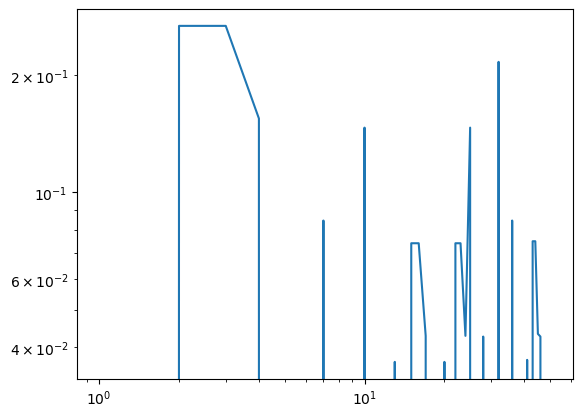

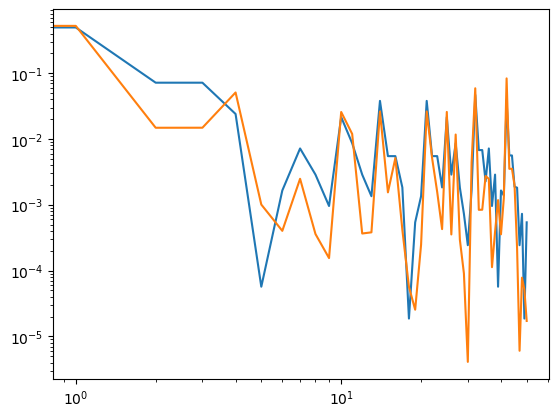

In [40]:
probb = (np.conjugate(m.forward(m.weights)) * m.forward(m.weights)).real

print(probb)
print(m.weights)
plt.plot(m.forward(m.weights))
plt.loglog()
plt.show()
prob_samples=np.average((np.conjugate(m.psi_batches) * m.psi_batches),axis=0).real

plt.plot(probb)
plt.plot(prob_samples)
plt.loglog()
plt.show()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


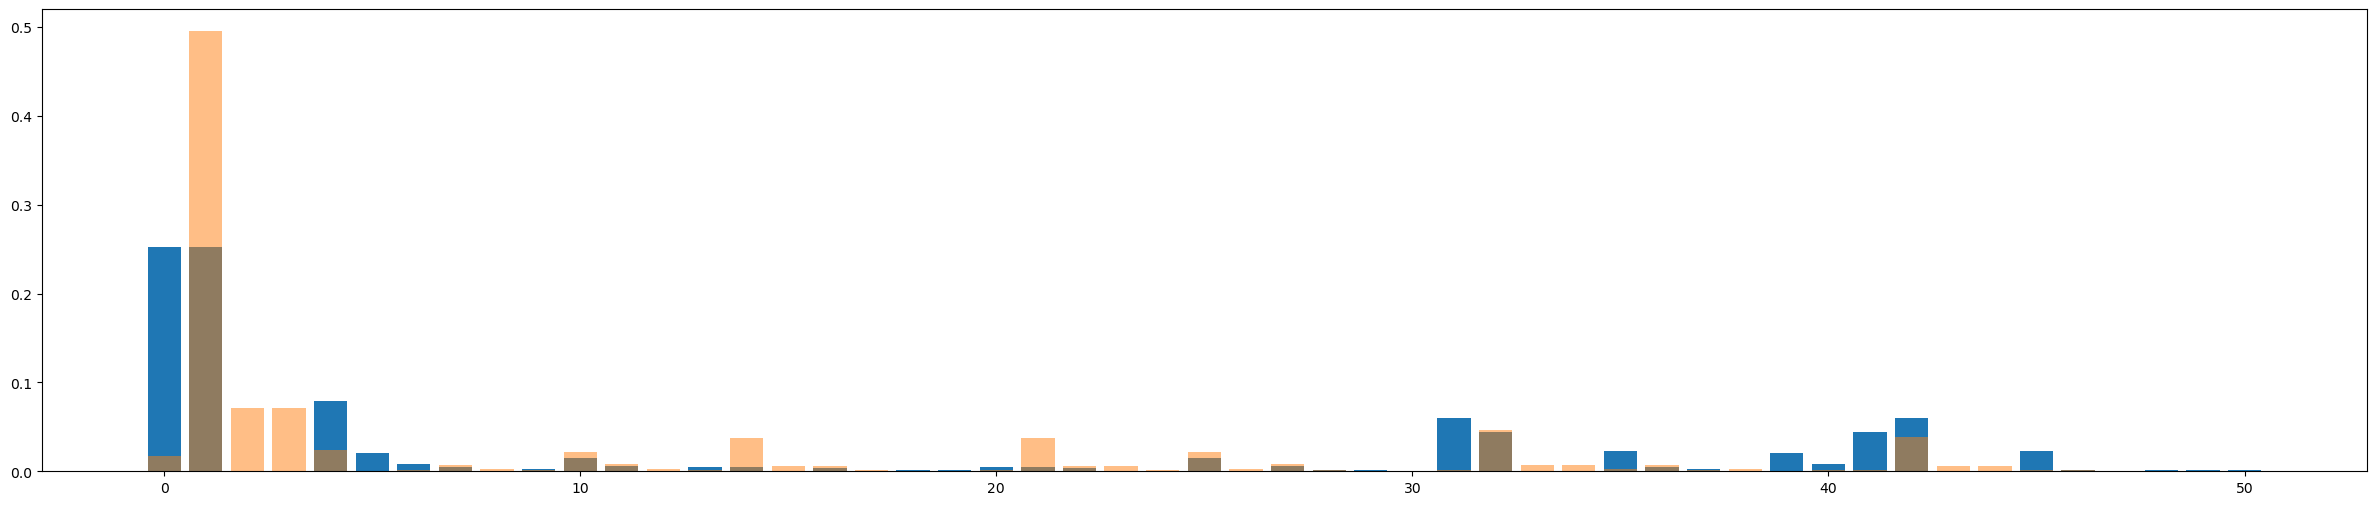

In [30]:
plt.figure(figsize=(30,6))

plt.bar(np.arange(psi0.shape[0]),(np.conjugate(psi0) * psi0).real)

plt.bar(np.arange(m.psi.shape[0]),probb,alpha=0.5)

#plt.bar(np.arange(m.psi.shape[0]),prob_samples,alpha=0.5)

print(m.weights)

In [31]:
fidelities=np.conjugate(np.einsum('ai,i->a',m.psi_batches,psi0))*np.einsum('ai,i->a',m.psi_batches,psi0)
print(np.average(fidelities))
for i in range(71,100):
    print(m.psi_batches[i].dot(NSMHamiltonian.hamiltonian.dot(m.psi_batches[i])))
    fidelities=np.conjugate(np.einsum('i,i->',m.psi_batches[i],psi0))*np.einsum('i,i->',m.psi_batches[i],psi0)
    print(np.average(fidelities))


0.3085393075697696
-35.99806332010709
0.7119815403143566
-36.26659382362861
0.6278855585003623
-35.875728151412666
0.4238494620781938
-34.96790050275006
0.5054560176021712
-35.58857463800183
0.40881448586231933
-36.20136833299011
0.646363842289732
-35.70463918161943
0.6979881709647634
-36.005194703375665
0.6691418168134177
-35.12940949319196
0.487587186812468
-35.915861992847695
0.6955717704640285
-36.33278007492956
0.6445236223131717
-36.298464731741035
0.7201373774290297
-35.77348564624942
0.7528787531986294
-36.423765198770006
0.633277659224783
-36.04737722705098
0.6313965254919602
-36.142372526246675
0.6692131820403657
-36.18043886453595
0.7264575258175321
-35.912030334536695
0.6473547710442249
-36.44192532962248
0.6394094834965104
-35.340068650755384
0.7419557687370886
-36.02782008402489
0.6233776899395376
-36.37131542210661
0.6533806464697294
-36.44253769399261
0.7563834345665382
-35.987118772581354
0.657968662534667
-36.01967163627548
0.6376368359046756
-35.38172552233302
0.6050

## Analysis Variational SDG

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=np.load('data/sdg/usdb_8_2_400_samples_10_steps_1000_parameters_1000_batches.npz')

weights=data['weights']
E=data['energy']
print(E)
variance=data['variance']
psi=data['psi']
history=data['history']
history_variance=data['history_variance']
prob=data['prob']
psis=data['psis']


-82.7106383403427


In [8]:
data=np.load('data/sdg/usdb_8_2_200_samples_10_steps_400_parameters_1000_batches.npz')

weights=data['weights']
E=data['energy']

print(E)
variance=data['variance']
psi=data['psi']
history_600=data['history']
history_variance=data['history_variance']
prob=data['prob']
psis=data['psis']

-85.22493868738701


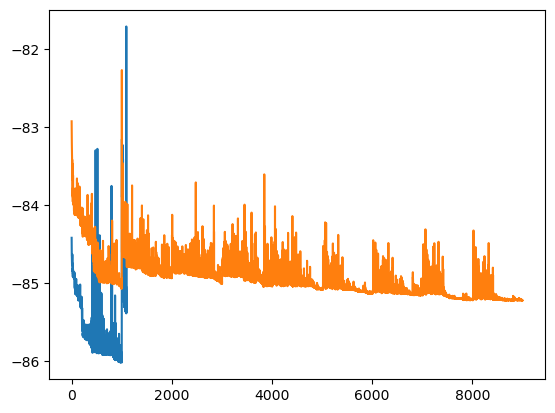

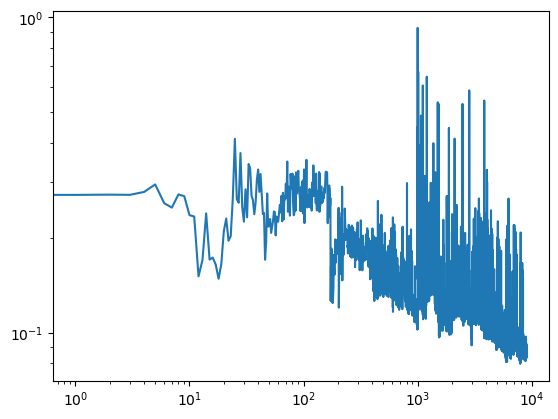

In [9]:
plt.plot(history)
plt.plot(history_600)
plt.show()

plt.plot(history_variance)
plt.loglog()
plt.show()